In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
import libpysal as lps

import matplotlib.pyplot as plt
import matplotlib.collections as mplc
%matplotlib inline
import seaborn as sns
import shapely

import descartes as des

import pysal as ps
import pysal.lib
from pysal.model.spreg import OLS
from pysal.model.spreg import ML_Error
from pysal.model.spreg import ML_Lag

from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pysal.model import mgwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.simplefilter('ignore') 

In [2]:
gwr_data = gpd.read_file('/Users/zahrajasmin-uddin/Desktop/coding/applications-sds/data/gwr_data.shp')
gwr_data = gwr_data.drop(['LSOA11CD', 'MSOA11CD', 'MSOA11NM','LAD11CD', 'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ','IMD2019_1', 'IMD2019_Lo', 'IMD2019_LS', 'IMD2019_2', 'IMD2019_3', 'IMD2019_4', 'IMD2019_5', 'IMD2019_6', 'IMD2019_7', 'IMD2019_8', 'IMD2019_9', 'IMD2019_10', 'IMD2019_11','IMD2019_12', 'IMD2019_13', 'IMD2019_14','IMD2019_15','IMD2019_16', 'IMD2019_17','IMD2019_18', 'IMD2019_19' ], axis=1)

In [3]:
gwr_data = gwr_data.drop([3708, 11548, 11532, 11549, 11904, 11905, 11907, 3756, 3757, 3758, 3762, 3763, 3774, 3802, 3803, 3804, 3805, 3806,
              3807, 3974, 3975, 5551, 5552, 5553, 5554, 5555, 5556, 5642, 5643, 5644, 5645, 5941, 5942, 5943, 5956, 5993, 5994, 
              5998, 5999, 6000, 6001, 6015, 6133, 6137, 6172, 6173, 6174, 15743, 15744, 15745, 15746, 16133, 23494, 23495, 23497, 
              11353, 11354, 5931, 5932, 5928, 5929, 5930])

In [4]:
gwr_data.shape

(24908, 13)

In [5]:
y, X = dmatrices('Numbers ~ IMD2019_In+IMD2019_Em+IMD2019_Ed+IMD2019_He+IMD2019_Cr+IMD2019_Ba+IMD2019_Li', data=gwr_data, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,35.306263,Intercept
1,13.945437,IMD2019_In
2,2.894196,IMD2019_Em
3,2.921313,IMD2019_Ed
4,3.661281,IMD2019_He
5,2.054193,IMD2019_Cr
6,2.211056,IMD2019_Ba
7,1.500960,IMD2019_Li


In [6]:
print(X.shape)

(24908, 8)


In [7]:
x = ['IMD2019_In','IMD2019_Em', 'IMD2019_Ed', 'IMD2019_He', 'IMD2019_Cr', 'IMD2019_Ba', 'IMD2019_Li'] # define input/independant variables
X = gwr_data.loc[:, x].dropna()
X = sm.add_constant(X)
y = np.array(gwr_data['Numbers'])

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     957.5
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:38:28   Log-Likelihood:                -99440.
No. Observations:               24908   AIC:                         1.989e+05
Df Residuals:                   24900   BIC:                         1.990e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8580      0.494     40.228      0.0

In [8]:
gwr_data['Centre'] = gwr_data['geometry'].centroid

In [9]:
gwr_data["X"] = gwr_data.Centre.map(lambda p: p.x)
gwr_data["Y"] = gwr_data.Centre.map(lambda p: p.y)

In [10]:
g_y = gwr_data['Numbers'].values.reshape((-1,1))
g_X = gwr_data[['IMD2019_In','IMD2019_Em', 'IMD2019_Ed', 'IMD2019_He', 'IMD2019_Cr', 'IMD2019_Ba', 'IMD2019_Li']].values
u = gwr_data['X']
v = gwr_data['Y']
g_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [11]:
sel = Sel_BW(g_coords, g_y, g_X)

In [ ]:
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

In [28]:
ldn = gpd.read_file('/Users/zahrajasmin-uddin/Desktop/coding/principles-sds/data/LSOA_IMD/LSOA_IMD2019.shp')
lsoas = ldn[['LSOA11CD', 'LSOA11NM', 'geometry']]
colnames = ['code', 'lsoa', 'geometry']
lsoas.columns = colnames
lsoas.head(4)

,code,lsoa,geometry
0,E01000001,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18..."


<AxesSubplot:>

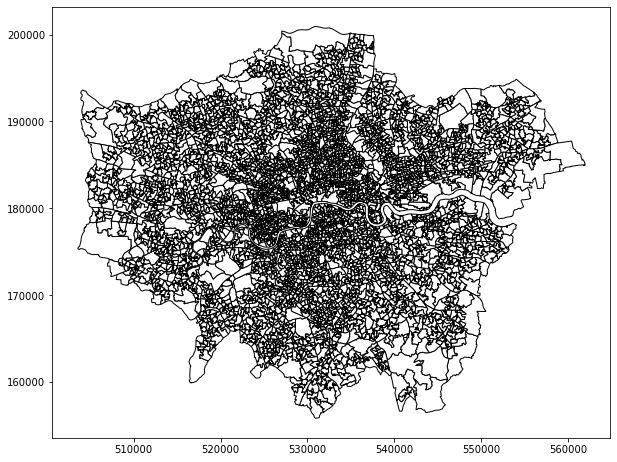

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
ldn.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})

In [29]:
from libpysal.weights.contiguity import Queen

In [30]:
wq = Queen.from_dataframe(ldn)
wq

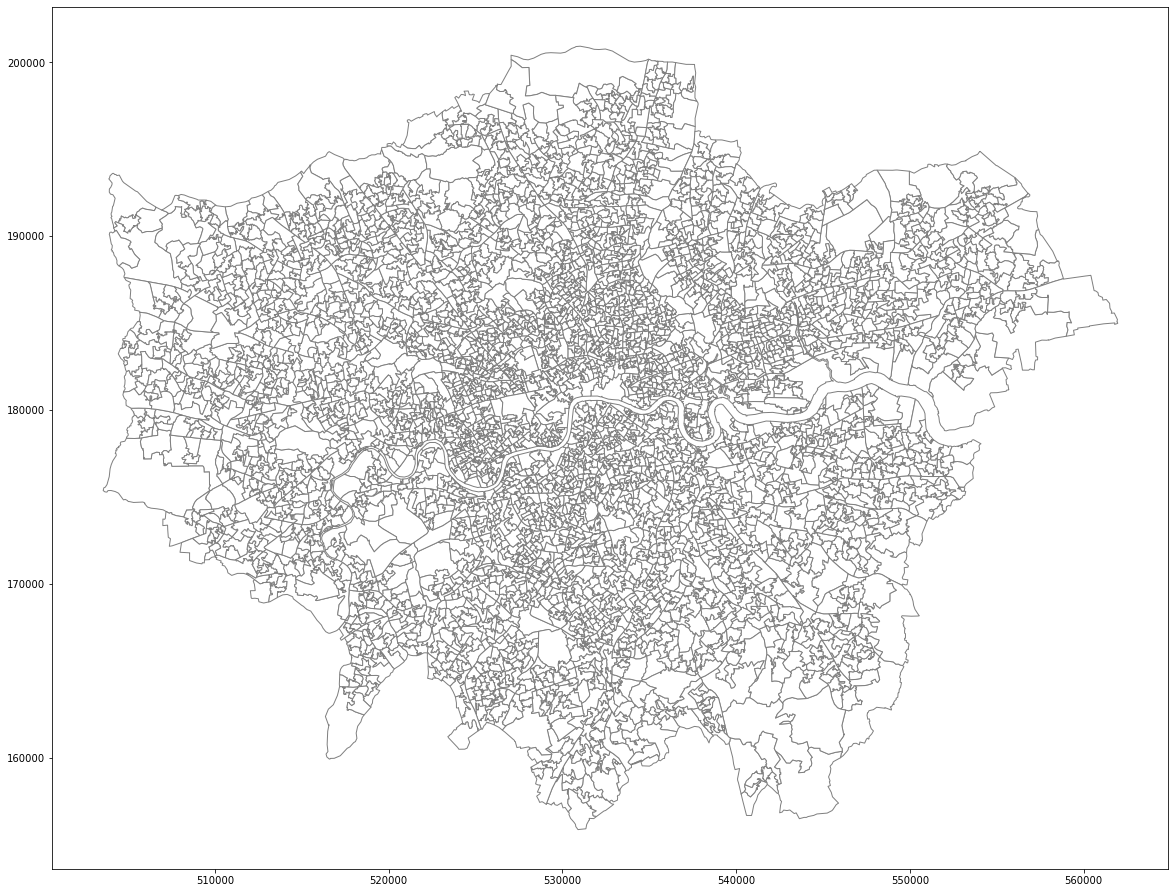

In [34]:
ax = ldn.plot(edgecolor='grey', facecolor='w', figsize=(20, 20))
f,ax = wq.plot(ldn, ax=ax, 
                   edge_kws=dict(color='b', linestyle=':', linewidth=0.5),
                   node_kws=dict(marker=''))

In [31]:
model = mgwr.gwr.GWR(g_coords, 
                     g_y,
                     g_X,
                    bw = 62)

In [32]:
results = model.fit()
results.summary()

Model type                                                         Gaussian
Number of observations:                                               24908
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          19625.526
Log-likelihood:                                                  -32374.411
AIC:                                                              64764.822
AICc:                                                             64766.829
BIC:                                                            -232435.787
R2:                                                                   0.212
Adj. R2:                                                              0.212

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [33]:
print(results.params.shape)

(24908, 8)


In [34]:
type(results.params)

numpy.ndarray

In [35]:
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

In [36]:
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)

In [37]:
df1=pd.DataFrame(gwr_data["LSOA11NM"])
df2 = df1.assign(intercept=data_params[0],
                IMD2019_In=data_params[1],
                 IMD2019_Em =data_params[2],
               IMD2019_Ed=data_params[3],
                IMD2019_He =data_params[4],
                  IMD2019_Cr = data_params[5],
                 IMD2019_Ba = data_params[6],
                 IMD2019_Li = data_params[7],
                 localR2=data_localR2[0])

df2.columns

Index(['LSOA11NM', 'intercept', 'IMD2019_In', 'IMD2019_Em', 'IMD2019_Ed',
       'IMD2019_He', 'IMD2019_Cr', 'IMD2019_Ba', 'IMD2019_Li', 'localR2'],
      dtype='object')

In [40]:
ldn = gpd.read_file('/Users/zahrajasmin-uddin/Desktop/coding/applications-sds/data/London-wards-2018/London-wards-2018_ESRI/London_Ward.shp')
ldn = ldn.drop(['LAGSSCODE', 'HECTARES', 'NONLD_AREA'], axis=1)
ldn = ldn[['NAME', 'DISTRICT', 'geometry']]
colnames = ['LSOA11NM', 'DISTRICT', 'geometry']
ldn.columns = colnames
ldn.shape

(657, 3)

In [41]:
#must use merge as df2 is df not gdf
ldn = ldn.merge(df2, left_on='LSOA11NM', right_on='LSOA11NM') 

ldn

,LSOA11NM,DISTRICT,geometry,intercept,IMD2019_In,IMD2019_Em,IMD2019_Ed,IMD2019_He,IMD2019_Cr,IMD2019_Ba,IMD2019_Li,localR2


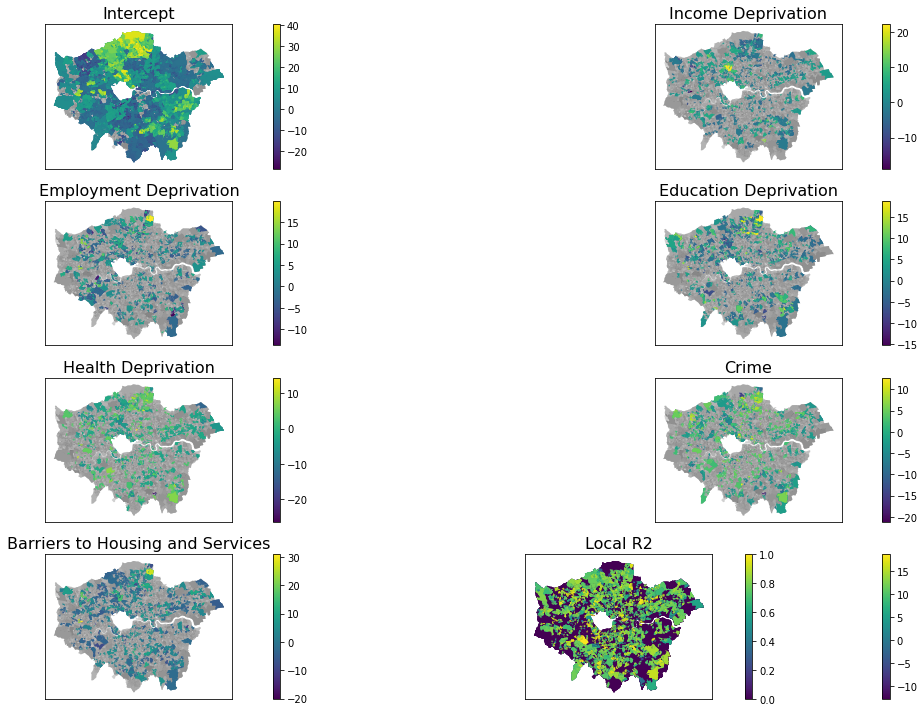

In [44]:
f,ax=plt.subplots(4,2,figsize=(30,20), subplot_kw=dict(aspect='equal'))

ax = ax.flatten()
titles = ['Intercept','Income Deprivation', 'Employment Deprivation', 'Education Deprivation', 
          'Health Deprivation', 'Crime', 'Barriers to Housing and Services', 'Living Environment Deprivation']

for i,row in enumerate(filtered_estimates.T):
    ldn_temp =ldn.assign(toplot=filtered_estimates.T[i])
    (ldn_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    
    (ldn_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='viridis',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
(ldn.assign(r2=results.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='viridis'))
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
f.tight_layout()
    
plt.show()

In [42]:
ldn['gwr_intercept'] = gwr_results.params[:,0]
ldn['gwr_imd_i'] = gwr_results.params[:,1]
ldn['gwr_imd_em'] = gwr_results.params[:,2]
ldn['gwr_imd_ed'] = gwr_results.params[:,3]
ldn['gwr_imd_h'] = gwr_results.params[:,4]
ldn['gwr_imd_c'] = gwr_results.params[:,5]
ldn['gwr_imd_b'] = gwr_results.params[:,6]
ldn['gwr_imd_l'] = gwr_results.params[:,7]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

In [43]:
ldn

,LSOA11NM,DISTRICT,geometry,intercept,IMD2019_In,IMD2019_Em,IMD2019_Ed,IMD2019_He,IMD2019_Cr,IMD2019_Ba,IMD2019_Li,localR2,gwr_intercept,gwr_imd_i,gwr_imd_em,gwr_imd_ed,gwr_imd_h,gwr_imd_c,gwr_imd_b,gwr_imd_l
0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.825298,1.118550e-14,-6.154799e-15,-4.080070e-15,-2.584738e-15,-3.719247e-15,-6.120104e-15,6.591949e-16
1,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.825298,1.765495e-13,-1.013072e-13,-3.369934e-14,-5.815302e-14,-5.938011e-14,-1.247167e-13,8.008640e-15
2,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.825298,5.416240e-15,-5.624841e-16,-1.836747e-15,-3.122502e-15,-1.320125e-15,-1.762913e-15,-6.635317e-16
3,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.825298,-7.093284e-15,2.670607e-15,3.776493e-15,2.610759e-15,2.501471e-15,4.555384e-15,-1.942890e-16
4,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.825298,-3.618633e-15,-1.695692e-16,2.547875e-16,1.945492e-15,5.555452e-16,2.096413e-15,6.975757e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24903,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.107599,-1.155947e-01,2.492431e-02,6.895014e-02,-4.069273e-02,6.005313e-02,6.058620e-02,-3.579085e-02
24904,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.177557,-2.655081e-01,-6.891037e-02,1.571811e-01,8.629507e-02,3.542255e-02,1.926411e-01,-2.437589e-02
24905,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.145700,-4.105916e-02,6.566513e-03,6.825374e-02,-8.686169e-02,6.713080e-02,9.597972e-02,-1.701075e-02
24906,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.177557,-2.655081e-01,-6.891037e-02,1.571811e-01,8.629507e-02,3.542255e-02,1.926411e-01,-2.437589e-02
